In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import category_encoders as en
import scipy.stats as ss
import random
from keras.layers import Input, Dense, Dropout
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.optimizers import SGD
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

import numpy as np
import pandas as pd

import pickle
import os

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss

import lightgbm as lgb

In [32]:
train = pd.read_csv("../inputs/Predict Fradulent Transactions/train.csv")
test = pd.read_csv("../inputs/Predict Fradulent Transactions/test.csv")
print(train.shape, test.shape)
train.head()

(348978, 51) (523466, 50)


,transaction_id,num_var_1,num_var_2,num_var_3,num_var_4,num_var_5,num_var_6,num_var_7,cat_var_1,cat_var_2,...,cat_var_34,cat_var_35,cat_var_36,cat_var_37,cat_var_38,cat_var_39,cat_var_40,cat_var_41,cat_var_42,target
0,id_11,2.302632e-08,0.040182,0.0,1.800000e-07,2.302632e-08,2.368421e-08,1.115205e-08,NaN,ce,...,0,0,0,0,0,0,0,0,0,0
1,id_33,7.965789e-06,0.157872,0.0,2.105000e-06,2.769737e-07,7.965789e-06,2.433058e-06,da,tn,...,0,0,0,0,0,0,0,0,0,0
2,id_51,7.828947e-08,0.089140,0.0,3.550000e-07,4.671053e-08,1.052632e-07,4.276014e-07,gf,ce,...,0,0,0,0,0,0,0,0,0,0
3,id_54,7.894737e-08,0.227239,0.0,1.050000e-06,1.381579e-07,2.190789e-07,1.848054e-08,NaN,ce,...,0,0,0,0,0,0,0,0,0,0
4,id_62,3.321053e-06,0.160410,0.0,2.105000e-06,2.769737e-07,3.340789e-06,2.152983e-06,da,tn,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data = pd.concat([train, test], axis=0)
data.index = list(range(data.shape[0]))
print(data.shape)
data.head()

(872444, 51)


,cat_var_1,cat_var_10,cat_var_11,cat_var_12,cat_var_13,cat_var_14,cat_var_15,cat_var_16,cat_var_17,cat_var_18,...,cat_var_9,num_var_1,num_var_2,num_var_3,num_var_4,num_var_5,num_var_6,num_var_7,target,transaction_id
0,NaN,db,iq,ep,ip,db,ep,tn,tn,ep,...,tn,2.302632e-08,0.040182,0.0,1.800000e-07,2.302632e-08,2.368421e-08,1.115205e-08,0.0,id_11
1,da,qt,iq,iq,hm,db,tn,tn,tn,tn,...,hr,7.965789e-06,0.157872,0.0,2.105000e-06,2.769737e-07,7.965789e-06,2.433058e-06,0.0,id_33
2,gf,mm,ce,tn,hr,db,ep,tn,tn,ep,...,hr,7.828947e-08,0.089140,0.0,3.550000e-07,4.671053e-08,1.052632e-07,4.276014e-07,0.0,id_51
3,NaN,es,iq,ep,ce,tn,ep,tn,tn,ep,...,ep,7.894737e-08,0.227239,0.0,1.050000e-06,1.381579e-07,2.190789e-07,1.848054e-08,0.0,id_54
4,da,xy,hr,iq,hm,db,tn,tn,tn,tn,...,ep,3.321053e-06,0.160410,0.0,2.105000e-06,2.769737e-07,3.340789e-06,2.152983e-06,0.0,id_62


In [4]:
cat_columns = [c for c in data.columns if "cat_var" in c]
num_columns = [c for c in data.columns if "num_var" in c]
np.mean(data.isnull())

cat_var_1         0.039514
cat_var_10        0.000000
cat_var_11        0.000000
cat_var_12        0.000000
cat_var_13        0.000000
cat_var_14        0.000000
cat_var_15        0.000000
cat_var_16        0.000000
cat_var_17        0.000000
cat_var_18        0.000000
cat_var_19        0.000000
cat_var_2         0.000000
cat_var_20        0.000000
cat_var_21        0.000000
cat_var_22        0.000000
cat_var_23        0.000000
cat_var_24        0.000000
cat_var_25        0.000000
cat_var_26        0.000000
cat_var_27        0.000000
cat_var_28        0.000000
cat_var_29        0.000000
cat_var_3         0.111428
cat_var_30        0.000000
cat_var_31        0.000000
cat_var_32        0.000000
cat_var_33        0.000000
cat_var_34        0.000000
cat_var_35        0.000000
cat_var_36        0.000000
cat_var_37        0.000000
cat_var_38        0.000000
cat_var_39        0.000000
cat_var_4         0.000000
cat_var_40        0.000000
cat_var_41        0.000000
cat_var_42        0.000000
c

In [5]:
pseudo_cat_columns = []
for c in cat_columns:
    dim = len(set(data[c]))
    print(c, dim)
    if dim > 10:
        pseudo_cat_columns.append(c)
        cat_columns.remove(c)
    elif dim == 1:
        cat_columns.remove(c)

cat_var_1 538
cat_var_11 5
cat_var_12 5
cat_var_13 52
cat_var_15 2
cat_var_16 2
cat_var_17 2
cat_var_18 2
cat_var_19 2
cat_var_2 63
cat_var_21 2
cat_var_22 2
cat_var_23 2
cat_var_24 2
cat_var_25 2
cat_var_26 2
cat_var_27 2
cat_var_28 2
cat_var_29 2
cat_var_3 621
cat_var_31 2
cat_var_32 2
cat_var_33 2
cat_var_34 2
cat_var_35 2
cat_var_36 2
cat_var_37 2
cat_var_38 1
cat_var_4 2
cat_var_40 2
cat_var_41 2
cat_var_42 1
cat_var_6 519
cat_var_8 466


In [6]:
len(pseudo_cat_columns), len(cat_columns)

(6, 34)

In [7]:
data[num_columns].describe()

,num_var_1,num_var_2,num_var_3,num_var_4,num_var_5,num_var_6,num_var_7
count,8.724440e+05,872444.000000,872444.000000,8.724440e+05,8.724440e+05,8.724440e+05,8.724440e+05
mean,1.868032e-05,0.160743,0.000017,4.428487e-05,7.441069e-06,1.523872e-05,2.128609e-05
std,1.764068e-03,0.131611,0.003382,2.439118e-03,6.072735e-04,1.521970e-03,1.959498e-03
min,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.671053e-08,0.084805,0.000000,3.550000e-07,4.671053e-08,4.407895e-08,1.720602e-08
50%,1.815789e-07,0.104261,0.000000,1.875000e-06,2.598684e-07,9.868421e-08,8.284379e-08
75%,6.513158e-07,0.160833,0.000000,2.105000e-06,2.769737e-07,4.644737e-07,3.575028e-07
max,5.427632e-01,1.000000,1.000000,1.000000e+00,2.171053e-01,4.605263e-01,1.000000e+00


In [8]:
np.mean(data[num_columns].isnull())

num_var_1    0.0
num_var_2    0.0
num_var_3    0.0
num_var_4    0.0
num_var_5    0.0
num_var_6    0.0
num_var_7    0.0
dtype: float64

* Na in the category columns can be treated as seperate category as in those columns levels are very high

In [9]:
train["target"].value_counts(normalize = True)

0    0.892922
1    0.107078
Name: target, dtype: float64

In [10]:
def plot_target_num(series1, series2):
    '''Series1: Target
        Series2: continous var'''
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    sns.boxplot(series1, series2)
    plt.subplot(122)
    sns.violinplot(series1, series2)
    plt.show()

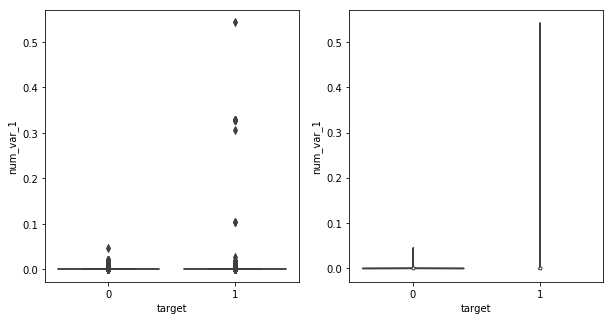

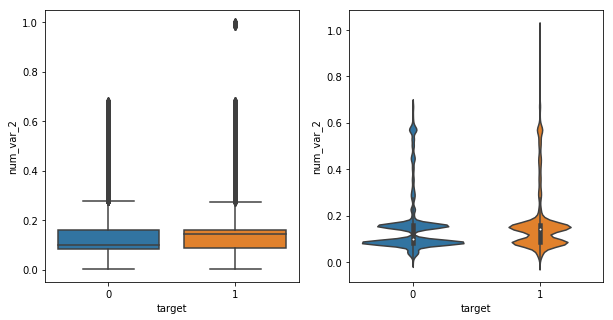

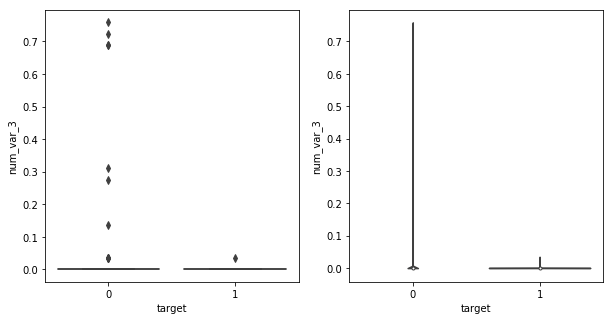

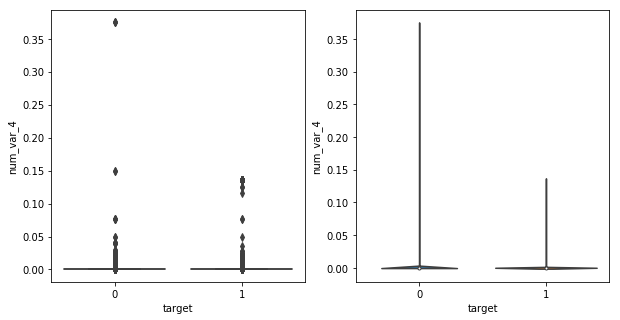

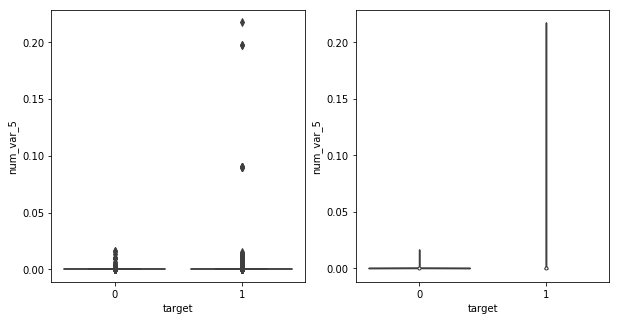

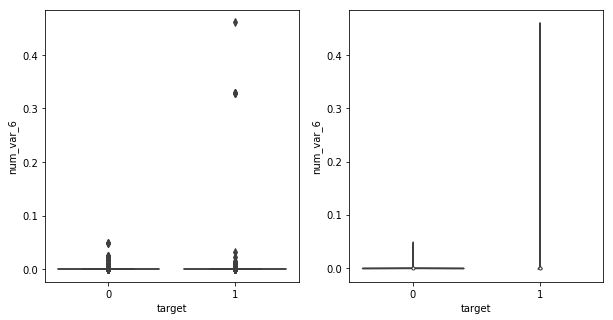

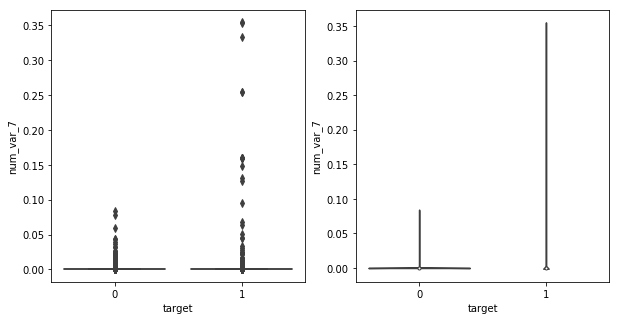

In [11]:
for c in num_columns:
    plot_target_num(train["target"], train[c])

* num_var_2 is important variable from initial observation

In [12]:
def plot_target_cat(target, cat_column_name, data):
    '''Function to plot target vs cat_columns
    Args:
        target: Target varaible name
        cat_column_name: categorical column name
        data: pandas dataframe'''
    temp = data[[target, cat_column_name]].groupby(cat_column_name).mean().reset_index()
    plt.figure()
    sns.pointplot(temp[cat_column_name], temp[target])
    plt.show()

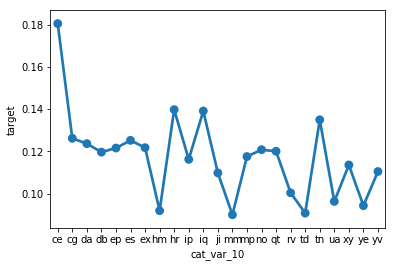

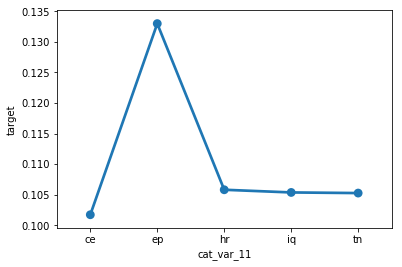

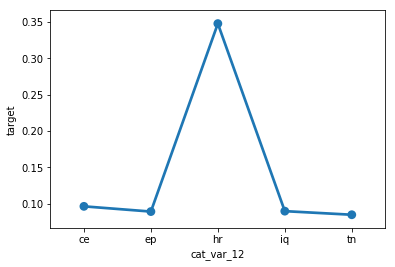

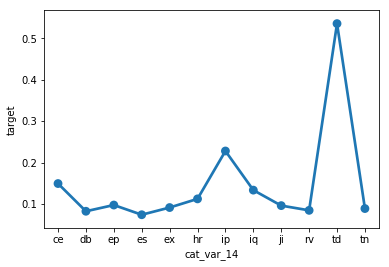

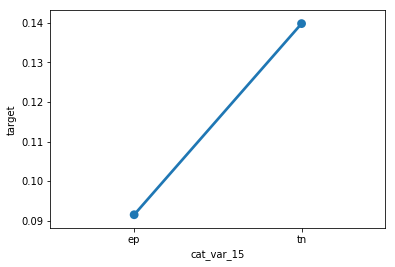

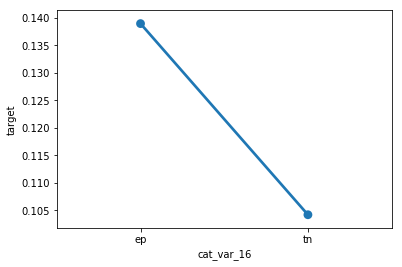

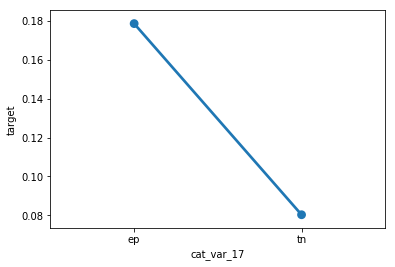

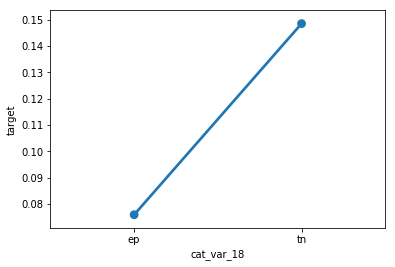

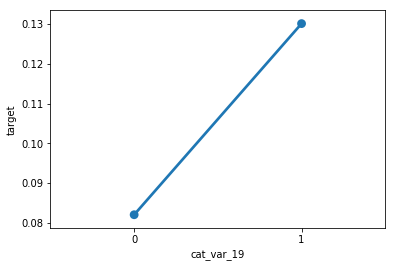

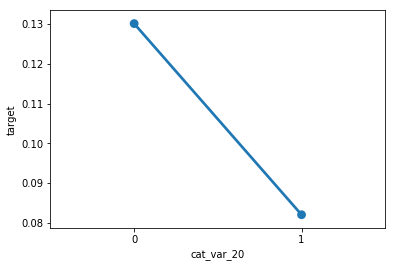

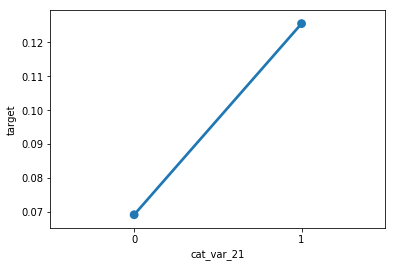

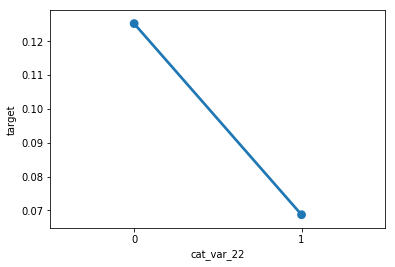

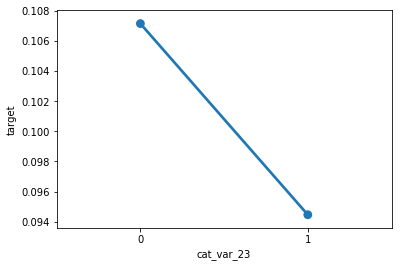

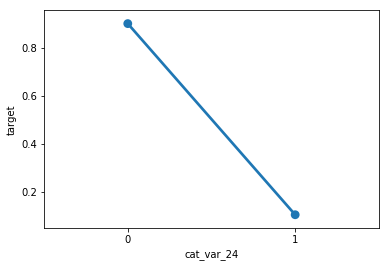

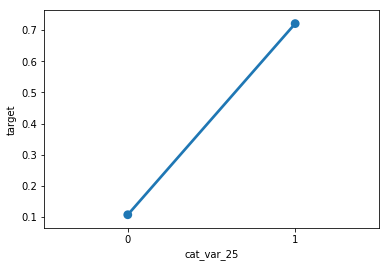

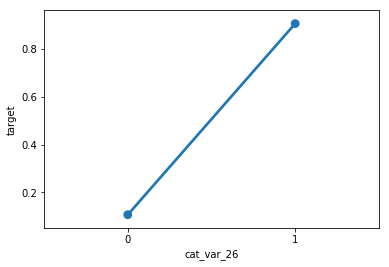

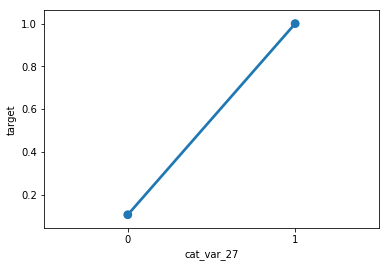

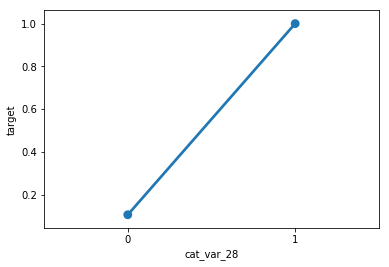

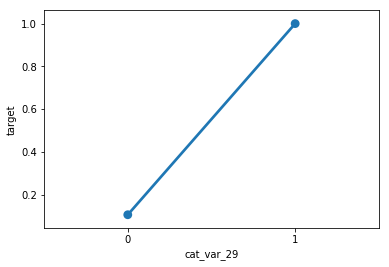

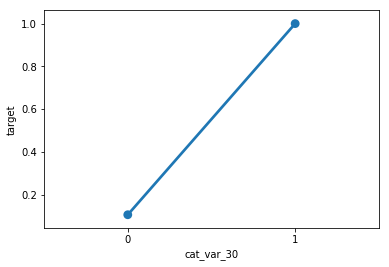

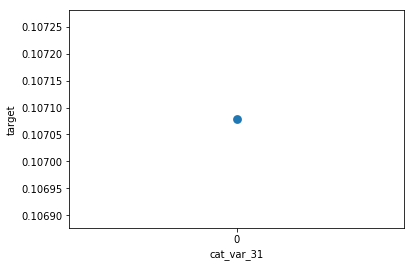

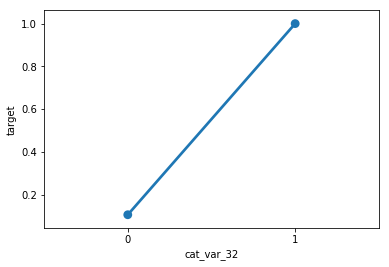

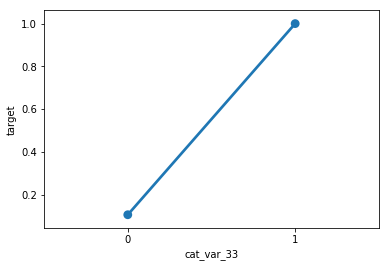

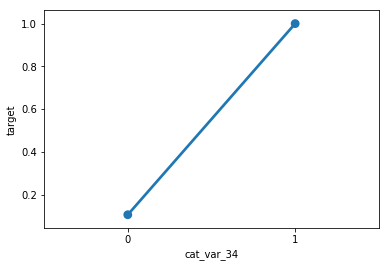

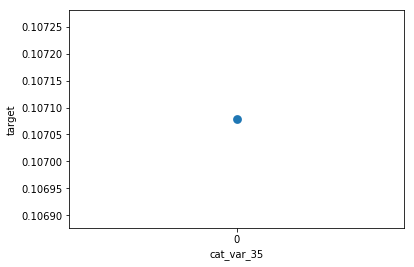

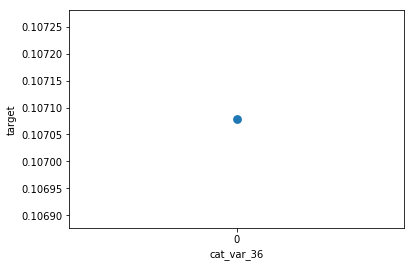

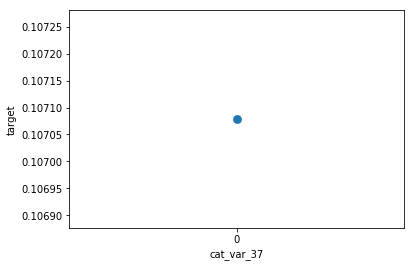

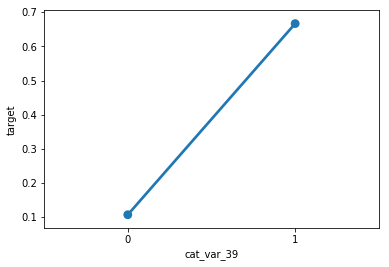

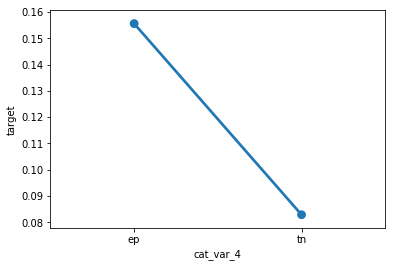

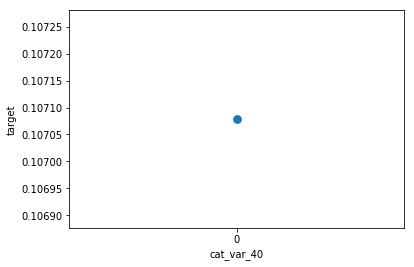

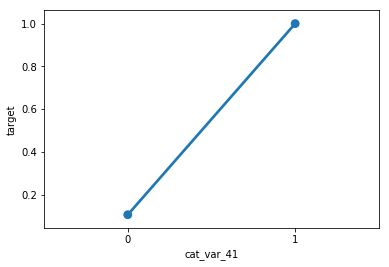

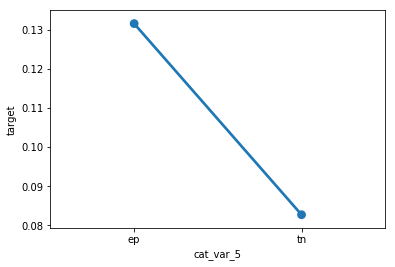

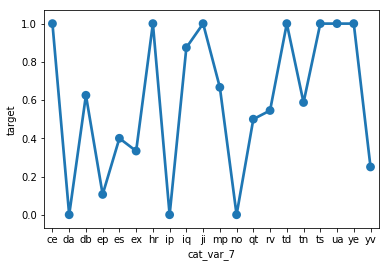

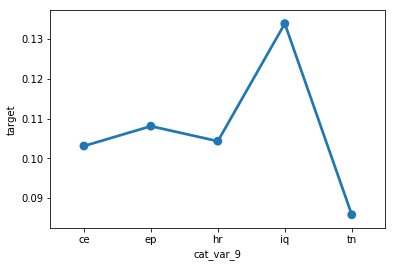

In [13]:
for c in cat_columns:
    plot_target_cat("target", c, train)

### Following Micheal Jahrer Advice

#### Step 1: Feature Engineering
I dislike this part most, my creativity is too low for an average competition lifetime, also luck plays huge role here. Therefore I like representation learning, its also an step towards AI. one-hot *cat features

In [14]:
one_hot = en.OneHotEncoder(verbose = 1, cols = cat_columns).fit(data[cat_columns])
temp = one_hot.transform(data[cat_columns])
data_f0 = pd.concat([data[num_columns], temp], axis = 1)
data_f0.shape

(872444, 170)

#### Step 2: Normalization
"The best what I found during the past and works straight of the box is "RankGauss". Its based on rank transformation. First step is to assign a linspace to the sorted features from 0..1, then apply the inverse of error function ErfInv to shape them like gaussians, then I substract the mean. Binary features are not touched with this trafo (eg. 1-hot ones). This works usually much better than standard mean/std scaler or min/max."

In [15]:
def rank_INT(series, c=3.0/8, stochastic=True):
    """ Perform rank-based inverse normal transformation on pandas series.
        If stochastic is True ties are given rank randomly, otherwise ties will
        share the same value. NaN values are ignored.
        Args:
            param1 (pandas.Series):   Series of values to transform
            param2 (Optional[float]): Constand parameter (Bloms constant)
            param3 (Optional[bool]):  Whether to randomise rank of ties
        
        Returns:
            pandas.Series
    """
    
    ## set seed
    np.random.seed(11)
    
    
    # Take original series indexes
    orig_idx = series.index

    # Drop NaNs
    series = series.loc[~pd.isnull(series)]

    # Get ranks
    if stochastic == True:
        # Shuffle by index
        series = series.loc[np.random.permutation(series.index)]
        # Get rank, ties are determined by their position in the series (hence
        # why we randomised the series)
        rank = ss.rankdata(series, method="ordinal")
    else:
        # Get rank, ties are averaged
        rank = ss.rankdata(series, method="average")

    # Convert numpy array back to series
    rank = pd.Series(rank, index=series.index)

    # Convert rank to normal distribution
    transformed = rank.apply(rank_to_normal, c=c, n=len(rank))
    
    return transformed[orig_idx]

def rank_to_normal(rank, c, n):
    # Standard quantile function
    x = (rank - c) / (n - 2*c + 1)
    return ss.norm.ppf(x)

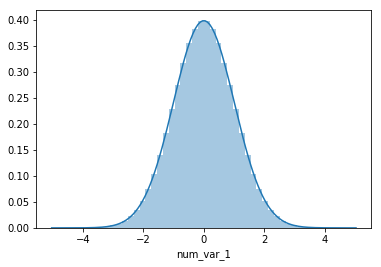

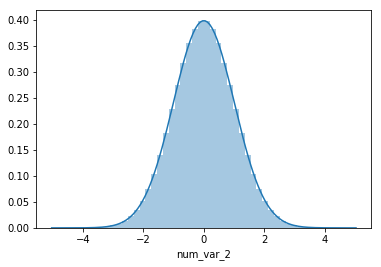

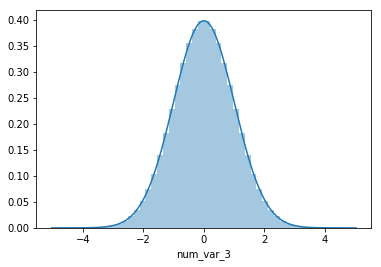

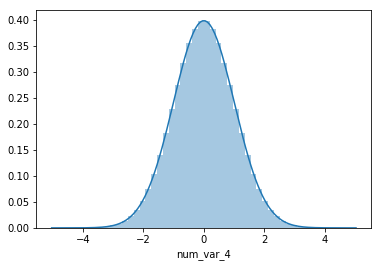

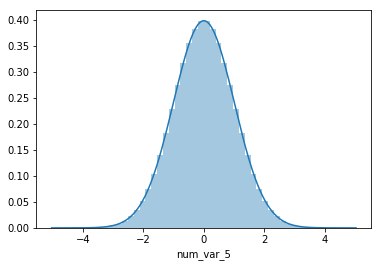

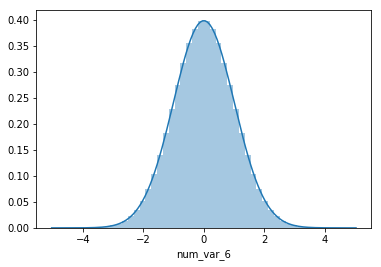

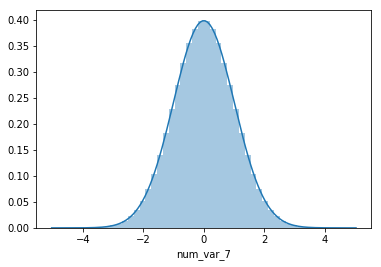

In [16]:
for col in num_columns:
    data_f0[col] = rank_INT(data_f0[col], stochastic=True)
    plt.figure()
    sns.distplot(data_f0[col])
    plt.show()

#### Step 3: Unsupervised Learning

"Denoising autoencoders (DAE) are nice to find a better representation of the numeric data for later neural net supervised learning. One can use train+test features to build the DAE. The larger the testset, the better :) An autoencoder tries to reconstruct the inputs features. So features = targets. Linear output layer. Minimize MSE. A denoising autoencoder tries to reconstruct the noisy version of the features. It tries to find some representation of the data to better reconstruct the clean one. With modern GPUs we can put much computing power to solve this task by touching peak floating point performance with huge layers. Sometimes I saw over 300W power consumption by checking nvidia-smi. So why manually constructing 2,3,4-way interactions, use target encoding, search for count features, impute features, when a model can find something similar by itself? The critical part here is to invent the noise. In tabular datasets we cannot just flip, rotate, sheer like people are doing this in images. Adding gaussian or uniform additive / multiplicative noise is not optimal since features have different scale or a discrete set of values that some noise just didnt make sense. I found a noise schema called "swap noise". Here I sample from the feature itself with a certain probability "inputSwapNoise" in the table above. 0.15 means 15% of features replaced by values from another row. Two different topologies are used by myself. Deep stack, where the new features are the values of the activations on all hidden layers. Second, bottleneck, where one middle layer is used to grab the activations as new dataset. This DAE step usually blows the input dimensionality to 1k..10k range."

In [18]:
def swap_noise(data, prob):
    """The function implements the noise schema called swap_noise.
    For each row in the dataframe select prob proportion of features and
    substitute them with another row from the data
    Args
        data: as matrix
        prob: Percentage of features to be replaced
    Returns
        data: with noise added"""
    dim = data.shape
    k = int(dim[1]*prob)
    columns = list(range(dim[1]))
    row_index = list(range(dim[0]))
    result = np.zeros(shape = dim)
    for index in row_index:
        feats_to_replace = random.sample(columns, k = k)
        select_random_row = random.sample(row_index, k = 1)
        feats = [c for c in columns if c not in feats_to_replace]
        result[index, feats] = data[index, feats]
        result[index, feats_to_replace] = data[select_random_row, feats_to_replace]
    return result

In [19]:
data_features_swapped = swap_noise(data_f0.as_matrix(), prob=0.15)

In [20]:
import pickle
with open("../utility/data_features_swapped.pkl", "wb") as w:
    pickle.dump(data_features_swapped, w)

In [6]:
def auto_encoder_model(dim, factor):
    '''Function creates an autoencoder model
    Args
        dim: Dimension of the input
        factor: Factor by which encoding dimension to contract or expand
    Output
        Model: Autoencoder model
        Encoder: Encoder Model
        Decoder: Decoder Model'''
    encoding_dim = np.int32(factor * dim)
    
    ## Input placeholder
    input_var = Input(shape=(dim,))
    
    ## 'encoded' is the encoding representation of the input
    encoded_layer1 = Dense(encoding_dim, activation = "relu", kernel_initializer='he_normal')(input_var)
    encoded_layer2 = Dense(encoding_dim, activation = "relu", kernel_initializer='he_normal')(encoded_layer1)
    encoded_layer3 = Dense(encoding_dim, activation = "relu", kernel_initializer='he_normal')(encoded_layer2)


    ## 'decoded' is the lossy reconstruction of the input
    decoded = Dense(dim, activation = "relu",kernel_initializer='he_normal')(encoded_layer3)

    ## this model maps an input to its reconstruction
    autoencoder = Model(input_var, decoded)
    
    ## seperated encoder model -- this model maps an input to its encoding representation
    encoder = Model(input_var, encoded_layer3)

    ## seperate decoder model - this model maps an encoding representation to its lossy comprehension
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]

    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    return autoencoder, encoder, decoder

In [ ]:
sgd = SGD(lr = 0.003, decay = 0.995)
dim = data_features_swapped.shape[1]
x_train, x_test = train_test_split(data_features_swapped, test_size = 0.4)
autoencoder, encoder, decoder = auto_encoder_model(dim, 9)
autoencoder.compile(optimizer= sgd, loss='mean_squared_error', )
callbacks = [ModelCheckpoint(os.path.join(os.getcwd(), "dae.hdf5"), monitor = 'val_loss', save_best_only=True)]#,
#             EarlyStopping(monitor='val_loss')]
autoencoder.fit(x_train, x_train,
               epochs = 500,
               batch_size = 128,
               shuffle = True,
                validation_data = (x_test, x_test),
                callbacks = callbacks)

encoded_data = encoder.predict(data_features_swapped)

Train on 523466 samples, validate on 348978 samples
Epoch 1/500
523466/523466 [==============================] - 362s - loss: 0.2401 - val_loss: 0.2386
Epoch 2/500
523466/523466 [==============================] - 345s - loss: 0.2381 - val_loss: 0.2379
Epoch 3/500
523466/523466 [==============================] - 345s - loss: 0.2377 - val_loss: 0.2376
Epoch 4/500
523466/523466 [==============================] - 348s - loss: 0.2374 - val_loss: 0.2374
Epoch 5/500
523466/523466 [==============================] - 368s - loss: 0.2373 - val_loss: 0.2373
Epoch 6/500
523466/523466 [==============================] - 363s - loss: 0.2372 - val_loss: 0.2372
Epoch 7/500
523466/523466 [==============================] - 366s - loss: 0.2372 - val_loss: 0.2372
Epoch 8/500
523466/523466 [==============================] - 356s - loss: 0.2371 - val_loss: 0.2371
Epoch 9/500
523466/523466 [==============================] - 350s - loss: 0.2371 - val_loss: 0.2371
Epoch 10/500
523466/523466 [====================

In [10]:
## load data_features_swapped
data_features_swapped = pickle.load(open("../utility/data_features_swapped.pkl", "rb"))
dim = data_features_swapped.shape[1]
factor = 9

In [23]:
## load the dae.hdf5 model
dae = load_model(os.path.join(os.getcwd(), "dae.hdf5"))
autoencoder, encoder, decoder = auto_encoder_model(dim=dim, factor=factor)

In [25]:
autoencoder.load_weights(os.path.join(os.getcwd(), "dae.hdf5"), by_name=True)

In [28]:
encoder.load_weights(os.path.join(os.getcwd(), "dae.hdf5"), by_name=True)
encoded_data = encoder.predict(data_features_swapped)

In [29]:
encoded_data.shape

(872444, 1530)

#### Step 4: Train the data

In [34]:
train.shape, test.shape

((348978, 51), (523466, 50))

In [48]:
## split the data into test and train
X = encoded_data[:train.shape[0], :]
X_test = encoded_data[train.shape[0]:, :]
print(X.shape, X_test.shape)

y = train["target"]

(348978, 1530) (523466, 1530)


In [ ]:
## saving X_train, X_test for future use
pickle.dump(X_train,open("../utility/X_train.pkl", "wb"))

with open("../utility/X_test.pkl", "wb") as w:
    pickle.dump(X_test, w)

In [83]:
def classification_network(dim):
    input_var = Input(shape=(dim, ))
    
    ## Layers
    layer_1 = Dense(4500, activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0005))(input_var)
    layer_1 = Dropout(0.5)(layer_1)
    
    layer_2 = Dense(1000, activation="relu",kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0005))(layer_1)
    layer_2 = Dropout(0.5)(layer_2)
    
    layer_3 = Dense(1000, activation="relu",kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0005))(layer_2)
    layer_3 = Dropout(0.5)(layer_3)
    
    output_layer = Dense(1, activation="sigmoid", kernel_initializer="he_normal")(layer_3)
    
    model = Model(inputs=input_var, outputs=output_layer)
    
    sgd = SGD(lr = 1e-4, decay=0.995)
    model.compile(sgd, loss = "binary_crossentropy", metrics = [])
    
    return model

In [79]:
class roc_auc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x, verbose=0)
        roc = roc_auc_score(self.y, y_pred)
        logs['roc_auc'] = roc_auc_score(self.y, y_pred)
        logs['norm_gini'] = ( roc_auc_score(self.y, y_pred) * 2 ) - 1

        y_pred_val = self.model.predict(self.x_val, verbose=0)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        logs['roc_auc_val'] = roc_auc_score(self.y_val, y_pred_val)
        logs['norm_gini_val'] = ( roc_auc_score(self.y_val, y_pred_val) * 2 ) - 1

        print('\rroc_auc: %s - roc_auc_val: %s - norm_gini: %s - norm_gini_val: %s' % (str(round(roc,5)),str(round(roc_val,5)),str(round((roc*2-1),5)),str(round((roc_val*2-1),5))), end=10*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [70]:
folds = 5
number_of_runs = 3
patience = 10

cv_LL = 0
cv_AUC = 0
cv_gini = 0
fpred = []
avpred = []
avreal = []
avids = []

In [84]:
cvlist = list(StratifiedKFold(n_splits=folds, random_state=5).split(X, y))

model = classification_network(dim=X.shape[1])
starttime = timer(None)
for i, (train_index, val_index) in enumerate(cvlist):
    X_train , X_val = X[train_index, :], X[val_index, :]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    for run in range(number_of_runs):
        np.random.seed()
        
        callbacks = [roc_auc_callback(training_data=(X_train, y_train),validation_data=(X_val, y_val)),
                     EarlyStopping(monitor='roc_auc_val', patience=patience, mode='max', verbose=1),
                     ModelCheckpoint('keras-5fold-run-01-v1-fold-' + str('%02d' % (i + 1)) + '-run-' + str('%02d' % (run + 1)) + '.hdf5',
                    monitor='roc_auc_val', mode='max', # mode must be set to max or Keras will be confused
                    save_best_only=True,
                    verbose=1)]
        #print("here............",X_train.shape, y_train.shape, X_val.shape, y_val.shape)
        nnet = model.fit(X_train, y_train,
                              epochs = 10,
                              batch_size=128,
                              validation_data=(X_val, y_val),
                              verbose=2,
                              shuffle=True,
                              callbacks = callbacks)
        #fit = nnet.fit(x=X_train, y = y_train)
        
        del nnet
        nnet = load_model('keras-5fold-run-01-v1-fold-' + str('%02d' % (i + 1)) + '-run-' + str('%02d' % (run + 1)) + '.hdf5')
        scores_val_run = nnet.predict(X_val, verbose=0)
        LL_run = log_loss(y_val, scores_val_run)
        print('\n Fold %d Run %d Log-loss: %.5f' % ((i + 1), (run + 1), LL_run))
        AUC_run = roc_auc_score(y_val, scores_val_run)
        print(' Fold %d Run %d AUC: %.5f' % ((i + 1), (run + 1), AUC_run))
       #print(' Fold %d Run %d normalized gini: %.5f' % ((i + 1), (run + 1), AUC_run*2-1))
        y_pred_run = nnet.predict(X_test, verbose=0)
        if run > 0:
            scores_val = scores_val + scores_val_run
            y_pred = y_pred + y_pred_run
        else:
            scores_val = scores_val_run
            y_pred = y_pred_run
            
# We average all runs from the same fold and provide a parameter summary for each fold. Unless something 
# is wrong, the numbers printed here should be better than any of the individual runs.

    scores_val = scores_val / number_of_runs
    y_pred = y_pred / number_of_runs
    LL = log_loss(y_val, scores_val)
    print('\n Fold %d Log-loss: %.5f' % ((i + 1), LL))
    AUC = roc_auc_score(y_val, scores_val)
    print(' Fold %d AUC: %.5f' % ((i + 1), AUC))
    print(' Fold %d normalized gini: %.5f' % ((i + 1), AUC*2-1))

# We add up predictions on the test data for each fold. Create out-of-fold predictions for validation data.

    if i > 0:
        fpred = pred + y_pred
        avreal = np.concatenate((avreal, y_val), axis=0)
        avpred = np.concatenate((avpred, scores_val), axis=0)
        avids = np.concatenate((avids, val_ids), axis=0)
    else:
        fpred = y_pred
        avreal = y_val
        avpred = scores_val
        avids = val_ids
    pred = fpred
    cv_LL = cv_LL + LL
    cv_AUC = cv_AUC + AUC

Train on 279182 samples, validate on 69796 samples
Epoch 1/10
roc_auc: 0.39831 - roc_auc_val: 0.40255 - norm_gini: -0.20337 - norm_gini_val: -0.1949          
Epoch 00000: roc_auc_val improved from -inf to 0.40255, saving model to keras-5fold-run-01-v1-fold-01-run-01.hdf5
762s - loss: 5.6206 - val_loss: 5.7344
Epoch 2/10
roc_auc: 0.39836 - roc_auc_val: 0.40259 - norm_gini: -0.20329 - norm_gini_val: -0.19481          
Epoch 00001: roc_auc_val improved from 0.40255 to 0.40259, saving model to keras-5fold-run-01-v1-fold-01-run-01.hdf5
670s - loss: 5.6186 - val_loss: 5.7337
Epoch 3/10
roc_auc: 0.39837 - roc_auc_val: 0.40261 - norm_gini: -0.20326 - norm_gini_val: -0.19479          
Epoch 00002: roc_auc_val improved from 0.40259 to 0.40261, saving model to keras-5fold-run-01-v1-fold-01-run-01.hdf5
631s - loss: 5.6175 - val_loss: 5.7333
Epoch 4/10
roc_auc: 0.39838 - roc_auc_val: 0.40262 - norm_gini: -0.20324 - norm_gini_val: -0.19477          
Epoch 00003: roc_auc_val improved from 0.40261 to

NameError: name 'start_time' is not defined